<a href="https://colab.research.google.com/github/Jorgvt/LibroDL/blob/main/Capitulo_3/Segmentacion/Segmentacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica 3. Segmentación de imágenes

Dejando atrás los ejercicios de clasificación, en esta práctica vamos a enfrentarnos a un nuevo tipo de problema: la segmentación de imágenes. Vamos a utilizar el dataset de *Oxford IIIT Pet*, que consiste en más de 7000 imágenes de diferentes razas de perros junto a su máscara de segmentación. El objetivo del ejercicio es conseguir entrenar un modelo que sea capaz de proporcionarnos las máscaras de segmentación a partir de las imágenes originales realizado un problema de clasificación multiclase por píxel.

Igual que en la práctica anterior, descargaremos el conjunto de datos de la librería `tensorflow_datasets`.

## Importación de las librerías

Antes de empezar a trabajar, cargamos todas las librerías que vamos a necesitar.

In [1]:
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tf.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow_datasets as tfds

In [2]:
## Opciones generales de Matplotlib para ajustar las figuras
plt.rcParams['figure.figsize'] = [9, 4]
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['image.cmap'] = 'gray'

In [3]:
## Este fragmento de código puede servir para solucionar algunos errores de CUDA
try:
    tf_gpus = tf.config.list_physical_devices('GPU')
    for gpu in tf_gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except:
    pass

## Carga de los datos

Para poder centrarnos en la parte interesante del ejercicio utilizaremos el dataset que se incluye en `tensorflow_datasets`. Podemos cargarlo de la siguiente manera:

In [4]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True, 
                          data_dir="./data/")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to ./data/oxford_iiit_pet/3.2.0.incomplete1AOSZ7/oxford_iiit_pet-train.tfrecord


  0%|          | 0/3680 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to ./data/oxford_iiit_pet/3.2.0.incomplete1AOSZ7/oxford_iiit_pet-test.tfrecord


  0%|          | 0/3669 [00:00<?, ? examples/s]

Dataset oxford_iiit_pet downloaded and prepared to ./data/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


A diferencia de la práctica anterior, si no especificamos ningún valor para el parámetro `split` al utilizar `.load()`, `dataset` es un diccionario que contiene tanto el dataset de entrenamiento como el de test. Esto depende de cómo ha sido construido el dataset original.

In [5]:
print(dataset.keys())

dict_keys(['test', 'train'])


Podemos ver la cantidad de elementos que hay en cada conjunto de datos a partir del objeto `info`. Vemos que están prácticamente repartidos por igual:

In [6]:
print(f"Muestras de entrenamiento: {info.splits['train'].num_examples}")
print(f"Muestras de test: {info.splits['test'].num_examples}")

Muestras de entrenamiento: 3680
Muestras de test: 3669


### Exploración de los datos

Como ya sabemos, los conjuntos de datos son objetos `PrefetchDataset`. Podemos explorar uno de estos ejemplos para ver qué información contiene y cómo son las imágenes y las máscaras iterando sobre el objeto:

In [7]:
for sample in dataset['train']:
    break
sample.keys()

dict_keys(['file_name', 'image', 'label', 'segmentation_mask', 'species'])

Ahora, cada elemento del mismo contiene:

- La ruta de la imagen a cargar.
- La propia imagen.
- La etiqueta.
- La máscara de segmentación correspondiente.
- La especie.

Y el problema está planteado de forma que en cada imagen podemos tener 3 etiquetas:

- Animal (1)
- Borde del animal (2)
- Fondo (3)

Podemos representar la imagen junto a su máscara de segmentación:

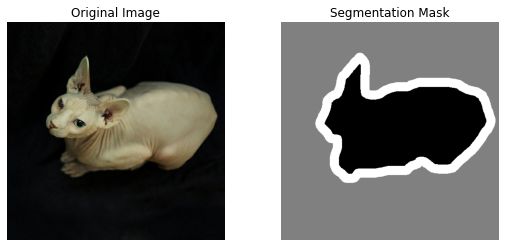

In [8]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(sample['image'].numpy().squeeze())
plt.title('Original Image')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(sample['segmentation_mask'].numpy().squeeze())
plt.title('Segmentation Mask')
plt.axis('off')
plt.savefig("Images/sample_img.png")
plt.show()

Siguiendo el procedimiento habitual vamos a comprobar los rangos de las imágenes por canal y sus dimensiones:

In [9]:
maxs = sample['image'].numpy().max(axis=(0,1))
mins = sample['image'].numpy().min(axis=(0,1))
ranges = [(m, M) for m, M in zip(mins, maxs)]

print("Rangos: {}, {}, {}".format(*ranges))
print("Dimensiones: ", sample['image'].shape)

Rangos: (0, 253), (0, 255), (0, 254)
Dimensiones:  (500, 500, 3)


Comprobamos también si todas las imágenes tienen el mismo tamaño:

In [10]:
shapes = []
for sample in dataset['train']:
    shapes.append(sample['image'].numpy().shape)
len(set(shapes))

709

En el caso de un problema de segmentación también es recomendable que comprobemos cómo son las etiquetas de las máscaras y su distribución. Esto nos permitirá ver si el problema está muy desbalanceado o no:

In [11]:
np.unique(sample['segmentation_mask'].numpy())

array([1, 2, 3], dtype=uint8)

In [12]:
Counter(sample['segmentation_mask'].numpy().ravel())

Counter({1: 7154, 2: 56431, 3: 3915})

Como viene siendo habitual las imágenes están en el rango $[0,255]$, y las etiquetas de las máscaras son $\{1,2,3\}$. También hemos visto que hay muchos menos píxeles de borde (como era de esperar) que de fondo o animal, por lo que podríamos tener algunos problemas prediciendo esta clase. Vsto esto, sabemos que tenemos que normalizar las imágenes para que queden en el rango $[0,1]$ y restar 1 a las etiquetas de las máscaras para que sean $\{0,1,2\}$. Además, también hemos visto que las imágenes tienen tamaños diferentes, así que también tendremos que transformarlas para que tengan todas el mismo.

> La normalización es importante para que nuestra red pueda aprender, mientras que el cambio en las etiquetas se hace por convención, ya que las funciones de coste esperan recibir así las etiquetas.

### Preprocesado de los datos

Dado que estamos trabajando con un `Dataset` de `TensorFlow`, la forma más cómoda de aplicar una transformación sobre el dataset completo es utilizando el método `.map()`, que permite aplicar una función a todos los elementos del conjunto y nos devuelve un nuevo `Dataset` con los resultados. Para ello crearemos una función de preprocesado, `prepare_data()`, y la aplicaremos utilizando `.map()`.

Esta función tiene que servirnos para X cosas:

1. Normalizar las imágenes.
2. Ajustar las etiquetas de las máscaras de segmentación.
3. Redimensionar las imágenes para reducir su tamaño y hacer que sean todas iguales. Hay que prestar especial atención al método que se utiliza para redimensionar las máscaras, ya que algunos aplican interpolación y pueden generar números intermedios que no correspondan a ninguna etiqueta real. Para evitarlo utilizaremos el método `nearest`.
4. Devolver únicamente las imágenes y las máscaras para poder utilizar el `dataset` directamente en el método `.fit()`.

In [13]:
def prepare_data(sample, reshape_dims=(128,128)):
    
    image = sample['image']
    segmentation_mask = sample['segmentation_mask']

    image = tf.image.resize(image, reshape_dims)
    segmentation_mask = tf.image.resize(segmentation_mask, 
                                        reshape_dims, 
                                        method='nearest')
    
    image = image/255
    segmentation_mask = segmentation_mask-1
    return image, segmentation_mask

In [14]:
train = dataset['train'].map(prepare_data)
test = dataset['test'].map(prepare_data)

Una vez aplicado podemos volver a representar una imagen junto a su máscara para ver el resultado. También podemos comprobar que los rangos de las imágenes y las máscaras son correctos.

In [15]:
for img, seg_mask in train:
    maxs = img.numpy().max(axis=(0,1))
    mins = img.numpy().min(axis=(0,1))
    ranges = [(m, M) for m, M in zip(mins, maxs)]

    print("Rangos: {}, {}, {}".format(*ranges))
    print("Dimensiones:", img.shape)
    print("Etiquetas: ", np.unique(seg_mask.numpy()))
    break

Rangos: (0.0, 0.7803567), (0.0, 0.7918505), (0.0, 0.6729023)
Dimensiones: (128, 128, 3)
Etiquetas:  [0 1 2]


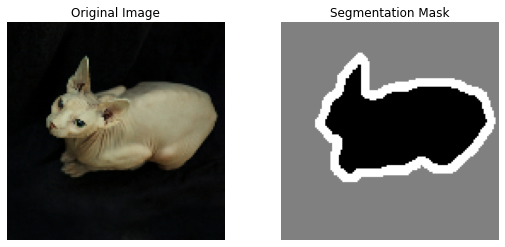

In [16]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(img.numpy().squeeze())
plt.title('Original Image')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(seg_mask.numpy().squeeze())
plt.title('Segmentation Mask')
plt.axis('off')
# plt.savefig("Images/sample_prepared_img.png")
plt.show()

La única diferencia apreciable es que ahora están menos definidos los bordes.

### Generalidades

Durante esta práctica vamos a entrenar y comparar muchos modelos. Para realizar estas comparaciones vamos a representar sus dinámicas de entrenamiento (es una buena forma de apreciar el sobre-entrenamiento) y también representaremos los resultados en los diferentes conjuntos que hemos creado anteriormente. Por todo esto es buena idea definir previamente unas funciones genéricas que nos sirvan para mantener el código más limpio y sencillo.

In [17]:
def plot_history(history):

    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], 'k-o', 
             label = "Entrenamiento")
    plt.plot(history.history['val_loss'], 'k--*', 
             label = "Validación")
    plt.ylabel('Loss')
    plt.xlabel('Épocas')
    plt.title('Loss del modelo')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(np.array(history.history['accuracy'])*100, 'k-o', 
             label="Entrenamiento")
    plt.plot(np.array(history.history['val_accuracy'])*100, 'k--*', 
             label="Validación")
    plt.ylabel('% Tasa de acierto')
    plt.xlabel('Épocas')
    plt.title('Tasa de acierto del modelo')
    plt.legend()

    return

In [18]:
def show_results(model, dataset, n=5, random=False):
    if random: dataset=dataset.shuffle(n)
    for x, y in dataset.batch(n):
        pred = model(x)
        break
    fig, axes = plt.subplots(2, n)
    for col in range(n):
        axes[0,col].imshow(y[col].numpy().squeeze())
        axes[0,col].set_title('Original')
        axes[0,col].axis('off')
        axes[1,col].imshow(np.argmax(pred[col].numpy().squeeze(),-1))
        axes[1,col].set_title('Predicted')
        axes[1,col].axis('off')
    fig.tight_layout()
    # plt.show()

## Definición del modelo

Los modelos por excelencia para resolver problemas de segmentación se basan en una estructura encoder-decoder que toma una imagen como entrada y devuelve una imagen que tiene tantos canales como clases diferentes a predecir. Esta parte es clave, ya que es lo que nos permite plantear un problema de clasificación por pixel.

El objetivo es conseguir que la salida del modelo sea una imagen del mismo tamaño que la imagen de entrada con tantos canales como clases posibles tenemos, de forma que solamente habrá que aplicar una función `softmax` en la dirección de los canales para obtener el canal (o la clase) más probable para cada pixel.

Esta arquitectura se puede plantear con la API Secuencial. Como es habitual, utilizaremos *Adam* como optimizador y la función de coste `tf.losses.SparseCategoricalCrossentropy` porque tenemos un problema multi-clase donde las etiquetas vienen dadas por números enteros en el rango $[0, N_{clases})$. 

Ahora hemos utilizado operaciones de *Pooling* para reducir la dimensionalidad de los mapas de características conforme nos adentramos en la red, pero en este caso vamos a utilizar `strides`. La justificación principal es que las operaciones de *Pooling* son muy útiles para resumir información, pero pierden la referencia de la localización espacial de esta información. Al reducir la dimensionalidad utilizando `strides` esta información espacial se mantiene mejor durante la red y proporciona mejores resultados para tareas de segmentación o generación de datos dónde la espacialidad es importante. De forma contraria, utilizaremos convoluciones traspuestas para recuperar el tamaño de la imagen original. En posteriores capítulos profundizaremos un poco más en esta operación, pero por ahora solamente tenemos que saber que es la operación contraria a la convolución y que, si utilizamos `strides`, podemos aumentar el tamaño de las imágenes por un factor igual a la cantidad de `strides`.

In [19]:
model = tf.keras.models.Sequential([
    layers.Conv2D(filters=32, kernel_size=3, padding='same', 
                  activation='relu', strides=2, 
                  input_shape=(128,128,3)),
    layers.Conv2D(filters=64, kernel_size=3, padding='same', 
                  activation='relu', strides=2),
    layers.Conv2D(filters=128, kernel_size=3, padding='same', 
                  activation='relu', strides=2),
    layers.Conv2D(filters=256, kernel_size=3, padding='same', 
                  activation='relu', strides=2),
    layers.Conv2DTranspose(filters=128, kernel_size=3, padding='same', 
                           activation='relu', strides=2),
    layers.Conv2DTranspose(filters=64, kernel_size=3, padding='same', 
                           activation='relu', strides=2),
    layers.Conv2DTranspose(filters=32, kernel_size=3, padding='same', 
                           activation='relu', strides=2),
    layers.Conv2DTranspose(filters=3, kernel_size=3, padding='same', 
                           activation='softmax', strides=2, ),
])
model.summary()
model.compile(optimizer='adam', 
              loss=tf.losses.SparseCategoricalCrossentropy(), 
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 256)         295168    
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      295040    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 64)       73792     
 ranspose)                                              

La funcion `tensorflow.keras.utils.plot_model()` nos permite generar una imagen de la estructura de nuestra red. Para que funcione es necesario tener instalados `pydot` y `graphviz`, pero podemos instalar fácilmente los dos paquetes con `conda` (`conda install pydot graphviz`).

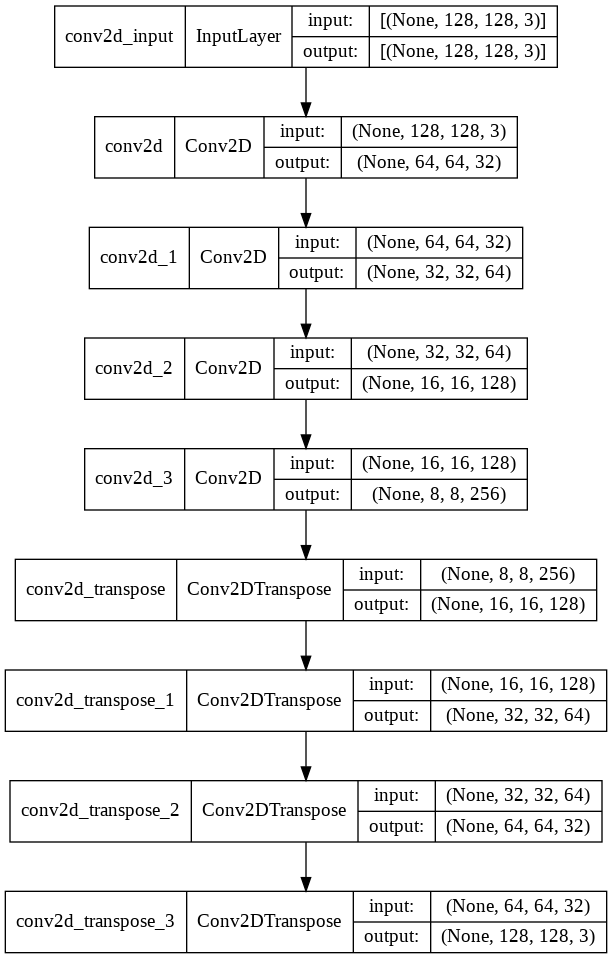

In [20]:
plot_model(model, to_file="Images/cnn_segmentation.png", show_shapes=True)

En este punto ya podemos entrenar nuestro modelo con normalidad:

In [21]:
history = model.fit(train.batch(64), 
                    epochs=15, 
                    validation_data=test.batch(64))

Epoch 1/15
58/58 [==============================] - 34s 431ms/step - loss: 0.9270 - accuracy: 0.5825 - val_loss: 0.8726 - val_accuracy: 0.5796
Epoch 2/15
58/58 [==============================] - 24s 420ms/step - loss: 0.7929 - accuracy: 0.6413 - val_loss: 0.8629 - val_accuracy: 0.6192
Epoch 3/15
58/58 [==============================] - 25s 428ms/step - loss: 0.7778 - accuracy: 0.6608 - val_loss: 0.8427 - val_accuracy: 0.6284
Epoch 4/15
58/58 [==============================] - 25s 424ms/step - loss: 0.7442 - accuracy: 0.6821 - val_loss: 0.7701 - val_accuracy: 0.6704
Epoch 5/15
58/58 [==============================] - 24s 424ms/step - loss: 0.7071 - accuracy: 0.6971 - val_loss: 0.7126 - val_accuracy: 0.6957
Epoch 6/15
58/58 [==============================] - 25s 425ms/step - loss: 0.6751 - accuracy: 0.7141 - val_loss: 0.6847 - val_accuracy: 0.7066
Epoch 7/15
58/58 [==============================] - 25s 427ms/step - loss: 0.6444 - accuracy: 0.7294 - val_loss: 0.6074 - val_accuracy: 0.7504

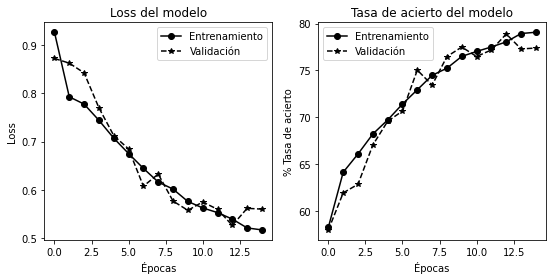

In [22]:
plot_history(history)
plt.savefig("Images/train_encoder_decoder.png")
plt.show()

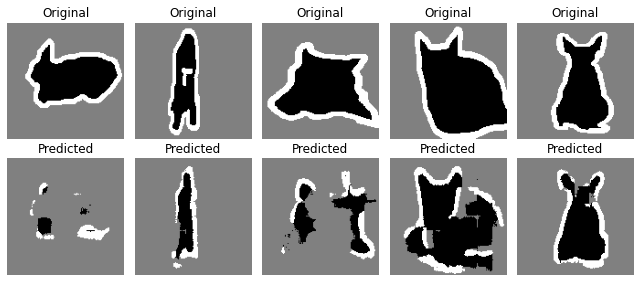

In [35]:
show_results(model, train, n=5)
# plt.suptitle("Train")
plt.savefig("Images/images_train_encoder_decoder.png")
plt.show()

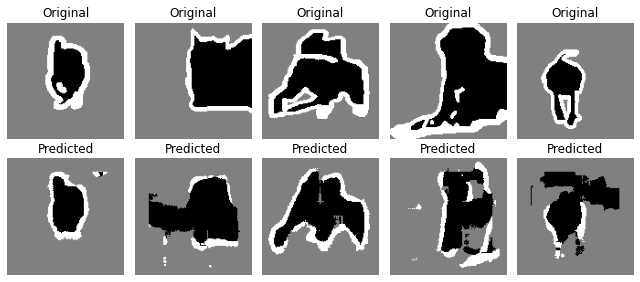

In [34]:
show_results(model, test, n=5)
# plt.suptitle("Test")
plt.savefig("Images/images_test_encoder_decoder.png")
plt.show()

## U-Net: Añadiendo conexiones entre capas

El resultado que obtenemos no está mal, pero no es todo lo bueno que podríamos esperar. Sí que es verdad que el modelo capta bastante rápido el contorno de las formas, pero falta definir mejor el resultado. Para ello Ronnenberger et. al (https://arxiv.org/pdf/1505.04597v1.pdf) decidieron incluir conexiones entre las capas del encoder y del decoder para favorecer la propagación de la información, algo que mejoró notablemente los resultados. 

Como ya podemos intuir, la arquitectura que queremos utilizar ya no es un modelo secuencial, así que tendremos que utilizar o bien la API Funcional o la herencia de clases. En este caso optamos por utilizar la API Funcional.

**Ejercicio: Plantea la misma arquitectura utilizando herencia de clases.**

### API Funcional

Al utilizar la API Funcional el proceso de definición de modelos es algo diferente: ahora definimos por un lado las capas que vamos a utilizar, y por otro definimos el flujo de la información a través de la red. Como ahora no tenemos que incluir todas las capas en una lista ordenada, podemos ir almacenando las salidas de cada capa en variables diferentes para elegir qué salidas entran en qué capas. Esto nos da unas posibilidades enormes a la hora de definir diferentes arquitecturas. 

Introducimos también la capa de concatenación `layers.concatenate()`, que sirve para concatenar dos tensores en la dirección dada. Por defecto toma la última dimensión, las de los canales. Puede llamar la atención que esta capa en realidad no es un objeto como las demás, si no que es una función. En realidad existen las dos versiones, pero como es una capa que no contiene ningún tipo de información, no es necesario utilizar la versión objeto cuando utilizamos la API Funcional.

Una vez hemos definido todas las capas, definimos un objeto `tf.keras.Input()` que representa una supuesta entrada al modelo. Este objeto en realidad contiene información de las dimensiones de los datos de entrada, y es necesario para que las capas puedas adaptar sus matrices de pesos acorde a esto. A partir de este objeto, aplicamos las diferentes capas hasta obtener la salida de la red. Teniendo la entrada y la salida, utilizamos el objeto `tf.keras.Model(input=inputs, output=outputs)` para instanciar el modelo final.

Veámoslo:

In [25]:
# Definición de las capas

## Encoder
conv_1 = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu', strides=2, input_shape=(128,128,3))
conv_1_1 = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu', strides=1)
conv_2 = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu', strides=2)
conv_2_1 = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu', strides=1)
conv_3 = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu', strides=2)
conv_3_1 = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu', strides=1)
conv_4 = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu', strides=2)
conv_4_1 = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu', strides=1)

## Decoder
convT_4_up = layers.Conv2DTranspose(128, kernel_size=3, padding='same', activation='relu', strides=2)
conv_3_up = layers.Conv2D(256, 3, padding='same', activation='relu')
convT_3_up = layers.Conv2DTranspose(64, kernel_size=3, padding='same', activation='relu', strides=2)
conv_2_up = layers.Conv2D(128, 3, padding='same', activation='relu')
convT_2_up = layers.Conv2DTranspose(32, kernel_size=3, padding='same', activation='relu', strides=2)
conv_1_up = layers.Conv2D(64, 3, padding='same', activation='relu')
convT_1_up = layers.Conv2DTranspose(3, kernel_size=3, padding='same', activation='relu', strides=2)
conv_up_1 = layers.Conv2D(32, 3, padding='same', activation='relu')
conv_up_2 = layers.Conv2D(3, 3, padding='same', activation='softmax')
# Definición del flujo de datos

## Definición de la entrada
x = tf.keras.Input(shape=(128,128,3))

## Encoding
x_conv_1 = conv_1(x) # 64
# x_conv_1 = conv_1_1(x_conv_1) # 64
x_conv_2 = conv_2(x_conv_1) # 32
# x_conv_2 = conv_2_1(x_conv_2) # 32
x_conv_3 = conv_3(x_conv_2) # 16
# x_conv_3 = conv_3_1(x_conv_3) # 16
x_conv_4 = conv_4(x_conv_3) # 8
# x_conv_4 = conv_4_1(x_conv_4) # 8

## Decoding
x_up_3 = convT_4_up(x_conv_4)
x_up_3 = layers.concatenate((x_conv_3, x_up_3))
x_up_3 = conv_3_up(x_up_3)


x_up_2 = convT_3_up(x_up_3)
x_up_2 = layers.concatenate((x_conv_2, x_up_2))
x_up_2 = conv_2_up(x_up_2)


x_up_1 = convT_2_up(x_up_2)
x_up_1 = layers.concatenate((x_conv_1, x_up_1))
x_up_1 = conv_1_up(x_up_1)


x_up = convT_1_up(x_up_1)
x_up = layers.concatenate((x, x_up))
x_up = conv_up_1(x_up)
x_up = conv_up_2(x_up)

In [26]:
u_net = tf.keras.Model(x, x_up)
u_net.summary()
u_net.compile(optimizer='adam', loss=tf.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 64, 64, 32)   896         ['input_1[0][0]']                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 32, 32, 64)   18496       ['conv2d_4[0][0]']               
                                                                                                  
 conv2d_8 (Conv2D)              (None, 16, 16, 128)  73856       ['conv2d_6[0][0]']           

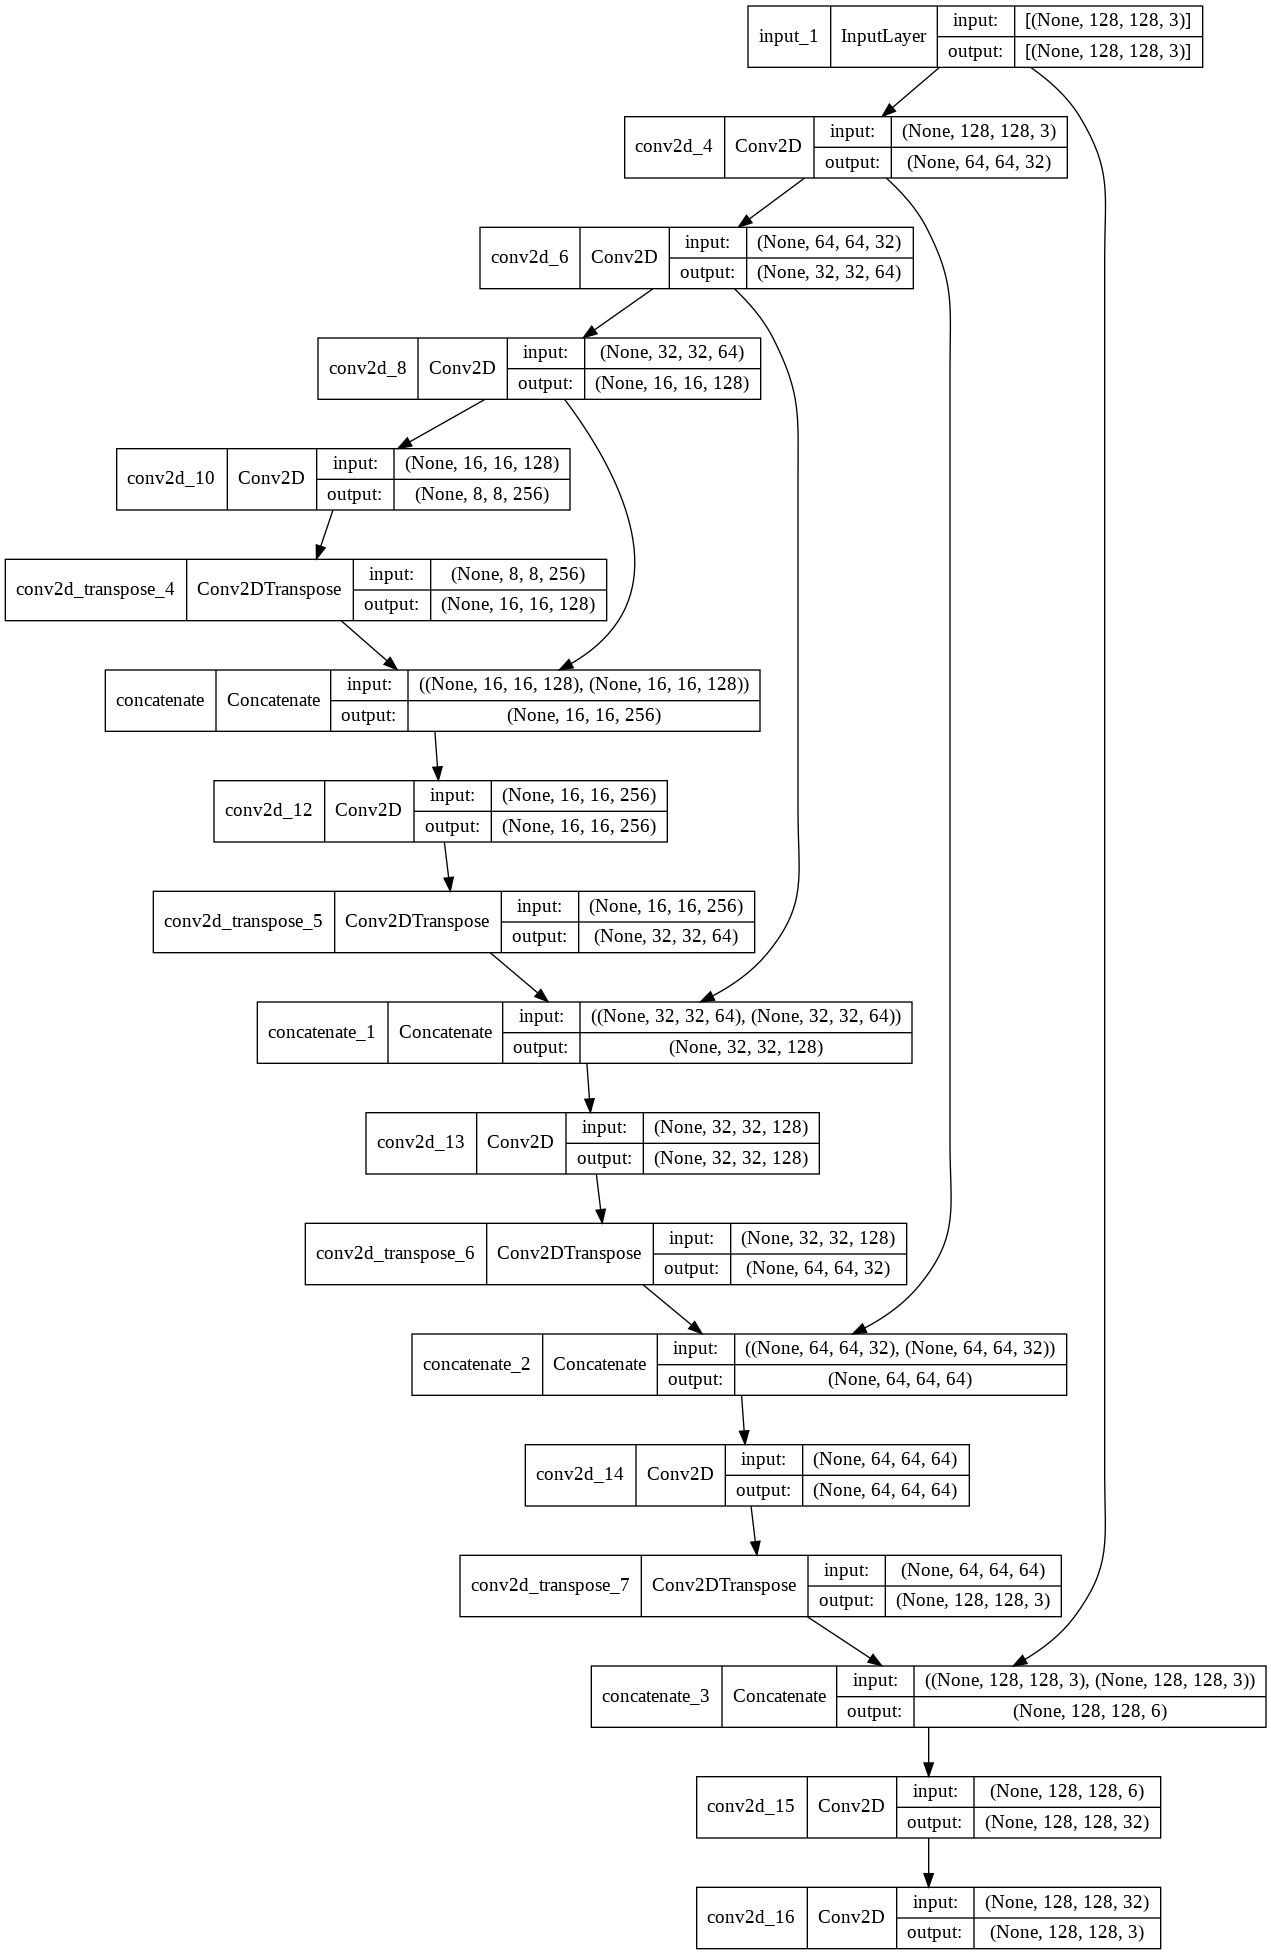

In [28]:
plot_model(u_net, to_file="u-net.png", show_shapes=True)

In [27]:
## Definición de los callbacks
cb_earlystopping = EarlyStopping(patience=4,
                                 monitor='val_accuracy')
cb_modelcheckpoint = ModelCheckpoint(filepath='model_unet.h5',
                                     monitor='val_accuracy',
                                     save_best_only=True)

history_unet = u_net.fit(train.batch(64), 
                         epochs=50, 
                         validation_data=test.batch(64),
                         callbacks=[cb_earlystopping, cb_modelcheckpoint])

Epoch 1/50
58/58 [==============================] - 35s 525ms/step - loss: 0.9397 - accuracy: 0.5752 - val_loss: 0.8795 - val_accuracy: 0.5773
Epoch 2/50
58/58 [==============================] - 35s 609ms/step - loss: 0.7859 - accuracy: 0.6565 - val_loss: 0.7931 - val_accuracy: 0.6912
Epoch 3/50
58/58 [==============================] - 27s 468ms/step - loss: 0.7152 - accuracy: 0.7209 - val_loss: 0.7777 - val_accuracy: 0.6870
Epoch 4/50
58/58 [==============================] - 27s 459ms/step - loss: 0.6768 - accuracy: 0.7344 - val_loss: 0.7039 - val_accuracy: 0.7111
Epoch 5/50
58/58 [==============================] - 27s 460ms/step - loss: 0.6291 - accuracy: 0.7500 - val_loss: 0.6482 - val_accuracy: 0.7346
Epoch 6/50
58/58 [==============================] - 27s 471ms/step - loss: 0.5666 - accuracy: 0.7753 - val_loss: 0.5559 - val_accuracy: 0.7786
Epoch 7/50
58/58 [==============================] - 35s 609ms/step - loss: 0.5247 - accuracy: 0.7937 - val_loss: 0.5433 - val_accuracy: 0.7890

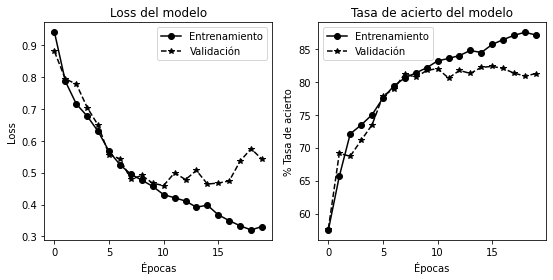

In [29]:
plot_history(history_unet)
plt.savefig("Images/train_unet.png")
plt.show()

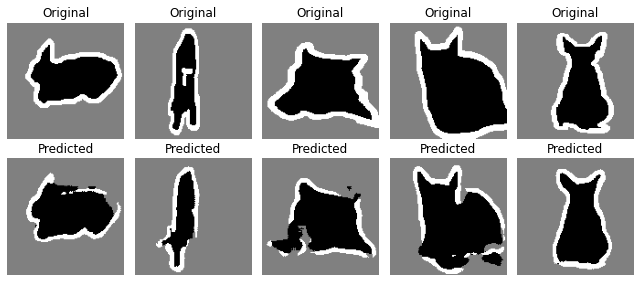

In [32]:
show_results(u_net, train, n=5)
# plt.suptitle("Train")
plt.savefig("Images/images_train_unet.png")
plt.show()

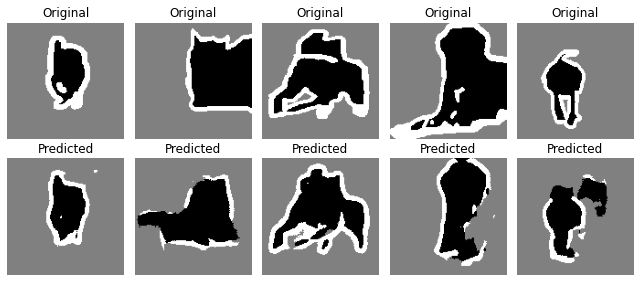

In [33]:
show_results(u_net, test, n=5, random=False)
# plt.suptitle("Test")
plt.savefig("Images/images_test_unet.png")
plt.show()

## Data Augmentation

En la práctica anterior hemos comprobado lo efectivo que puede ser el *Data Augmentation* cuando trabajamos con conjuntos de datos no demasiado grandes o sufrimos de sobre-ajuste. Ya hemos visto que en un problema de clasificación de imágenes no es demasiado complicado de implementar, pero al trabajar en un problema de segmentación aumenta ligeramente la complicación: tenemos que aplicar las mismas transformaciones a las imágenes y a las máscaras. No tiene sentido que rotemos la imagen original hacia un lado y la máscara correspondiente hacia el otro, nuestro modelo no podría extraer ninguna información útil de eso.

Para solventar esto podemos utilizar las semillas, al definir las transformaciones aleatorias del aumento de datos es posible establecer diferentes semillas para que el proceso aleatorio siempre sea igual. De esta manera nos podemos asegurar de que las imágenes y las máscaras se transforman de la misma manera.

Además de esta opción también podemos usar la librería `Albumentations`, que es una librería diseñada para implementar de forma rápida y sencilla una gran cantidad de aumento de datos para muchos problemas distintos basados en imágenes. Esta librería se va a encargar de transformar igual las imágenes y las máscaras para hacernos la vida más fácil.

**Ejercicio: Investiga como podrías aplicar *Data Augmentation* a un problema de segmentación sin utilizar `Albumentations`. Presta especial atención al uso de las semillas en los generadores aleatorios.**

### Albumentations

La liberaría se puede instalar fácilmente utilizando `pip`: `pip install -U albumentations`.

In [36]:
import albumentations as A

De forma muy similar a cómo lo hacíamos antes, solamente tendremos que definir una lista de las transformaciones que queremos utilizar y encapsularla dentro del objeto `A.Compose()`. La lista de transformaciones disponibles es muy extensa (https://albumentations.ai/docs/getting_started/transforms_and_targets/) pero vamos a utilizar: rotación y volteado horizontal.

In [37]:
augmentations = A.Compose([
    A.Rotate(limit=45),
    A.HorizontalFlip()
])

Una vez hemos definido las transformaciones deseadas simplemente tenemos que aplicarlas sobre la imagen y la máscara al mismo tiempo. El resultado de esta operación es un diccionario con las dos imágenes en las claves `image` y `mask` respectivamente. Para poder apreciar los resultados podemos aplicar la misma transformación varias veces y representar los diferentes resultados:

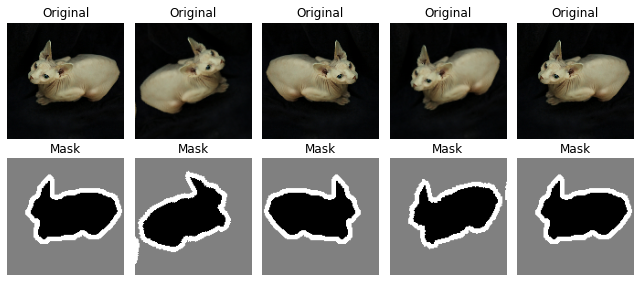

In [ ]:
n = 5
fig, axes = plt.subplots(2, n)
for col in range(n):
    aug_test = augmentations(image=img.numpy(), mask=seg_mask.numpy())
    axes[0,col].imshow(aug_test['image'].squeeze())
    axes[0,col].set_title('Original')
    axes[0,col].axis('off')
    axes[1,col].imshow(aug_test['mask'].squeeze())
    axes[1,col].set_title('Mask')
    axes[1,col].axis('off')
fig.tight_layout()
plt.savefig("Images/augmentations.png")
plt.show()

Solamente nos falta poder aplicarlas durante el entrenamiento a las imágenes de nuestro conjunto original. Para ello podemos crearnos una función que aplique las transformaciones y aplicarla sobre todo el dataset con el método `.map()`. Hay que tener en cuenta que ahora nuestros datasets devuelven dos elementos, la imagen y la máscara, por lo que habrá que cambiar ligeramente la definción de la función respecto a cuando definimos `prepare_data()`.

In [38]:
def augment_data(img, seg_mask):
    augmented_data = augmentations(image=img, mask=seg_mask)
    return augmented_data['image'], augmented_data['mask']

Hay que tener cuidado porque las funciones de *Albumentations* están hechas para utilizarse con `arrays` de *NumPy*. Esto quiere decir que tendremos que envolver la función que acabamos de crear dentro de una `tf.numpy_function()` para que *TensorFlow* sepa cómo manejarla:

In [39]:
def augment_data_2(img, seg_mask):
    aug_img = tf.numpy_function(func=augment_data, 
                                inp=[img, seg_mask], 
                                Tout=(tf.float32, tf.uint8))
                                
    return aug_img[0], aug_img[1]

Además, al utilizar una `tf.numpy_function()` el `Dataset` pierde las formas de los objetos que contiene, por lo que tendremos que volver a decirle cómo son los datos:

In [40]:
def set_shapes(img, seg_mask, 
               img_shape=(128,128,3), 
               seg_mask_shape=(128,128,1)):
    
    img.set_shape(img_shape)
    seg_mask.set_shape(seg_mask_shape)
    return img, seg_mask

Finalmente aplicamos las transformaciones sobre el `Dataset` de entrenamiento:

In [41]:
train_aug = train.map(augment_data_2).map(set_shapes)

In [53]:
# Definición de las capas

## Encoder
conv_1 = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu', strides=2, input_shape=(128,128,3))
conv_1_1 = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu', strides=1)
conv_2 = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu', strides=2)
conv_2_1 = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu', strides=1)
conv_3 = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu', strides=2)
conv_3_1 = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu', strides=1)
conv_4 = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu', strides=2)
conv_4_1 = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu', strides=1)

## Decoder
convT_4_up = layers.Conv2DTranspose(128, kernel_size=3, padding='same', activation='relu', strides=2)
conv_3_up = layers.Conv2D(256, 3, padding='same', activation='relu')
convT_3_up = layers.Conv2DTranspose(64, kernel_size=3, padding='same', activation='relu', strides=2)
conv_2_up = layers.Conv2D(128, 3, padding='same', activation='relu')
convT_2_up = layers.Conv2DTranspose(32, kernel_size=3, padding='same', activation='relu', strides=2)
conv_1_up = layers.Conv2D(64, 3, padding='same', activation='relu')
convT_1_up = layers.Conv2DTranspose(3, kernel_size=3, padding='same', activation='relu', strides=2)
conv_up_1 = layers.Conv2D(32, 3, padding='same', activation='relu')
conv_up_2 = layers.Conv2D(3, 3, padding='same', activation='softmax')
# Definición del flujo de datos

## Definición de la entrada
x = tf.keras.Input(shape=(128,128,3))

## Encoding
x_conv_1 = conv_1(x) # 64
# x_conv_1 = conv_1_1(x_conv_1) # 64
x_conv_2 = conv_2(x_conv_1) # 32
# x_conv_2 = conv_2_1(x_conv_2) # 32
x_conv_3 = conv_3(x_conv_2) # 16
# x_conv_3 = conv_3_1(x_conv_3) # 16
x_conv_4 = conv_4(x_conv_3) # 8
# x_conv_4 = conv_4_1(x_conv_4) # 8

## Decoding
x_up_3 = convT_4_up(x_conv_4)
x_up_3 = layers.concatenate((x_conv_3, x_up_3))
x_up_3 = conv_3_up(x_up_3)


x_up_2 = convT_3_up(x_up_3)
x_up_2 = layers.concatenate((x_conv_2, x_up_2))
x_up_2 = conv_2_up(x_up_2)


x_up_1 = convT_2_up(x_up_2)
x_up_1 = layers.concatenate((x_conv_1, x_up_1))
x_up_1 = conv_1_up(x_up_1)


x_up = convT_1_up(x_up_1)
x_up = layers.concatenate((x, x_up))
x_up = conv_up_1(x_up)
x_up = conv_up_2(x_up)

In [54]:
u_net = tf.keras.Model(x, x_up)
# u_net.summary()
u_net.compile(optimizer='adam', loss=tf.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [55]:
## Definición de los callbacks
cb_earlystopping = tf.keras.callbacks.EarlyStopping(patience=8,
                                                    monitor='val_accuracy')
cb_modelcheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath='model_unet.h5',
                                                        monitor='val_accuracy',
                                                        save_best_only=True)

history_unet = u_net.fit(train_aug.batch(64), 
                         epochs=50, 
                         validation_data=test.batch(64),
                         callbacks=[cb_earlystopping, cb_modelcheckpoint])

Epoch 1/50
58/58 [==============================] - 31s 498ms/step - loss: 0.9592 - accuracy: 0.5642 - val_loss: 0.9301 - val_accuracy: 0.5772
Epoch 2/50
58/58 [==============================] - 36s 632ms/step - loss: 0.8394 - accuracy: 0.6102 - val_loss: 0.7736 - val_accuracy: 0.6794
Epoch 3/50
58/58 [==============================] - 28s 481ms/step - loss: 0.7510 - accuracy: 0.7014 - val_loss: 0.7447 - val_accuracy: 0.7008
Epoch 4/50
58/58 [==============================] - 28s 478ms/step - loss: 0.7185 - accuracy: 0.7130 - val_loss: 0.7064 - val_accuracy: 0.7141
Epoch 5/50
58/58 [==============================] - 28s 482ms/step - loss: 0.6784 - accuracy: 0.7242 - val_loss: 0.6450 - val_accuracy: 0.7360
Epoch 6/50
58/58 [==============================] - 28s 477ms/step - loss: 0.6414 - accuracy: 0.7389 - val_loss: 0.6484 - val_accuracy: 0.7308
Epoch 7/50
58/58 [==============================] - 36s 632ms/step - loss: 0.6165 - accuracy: 0.7501 - val_loss: 0.5672 - val_accuracy: 0.7747

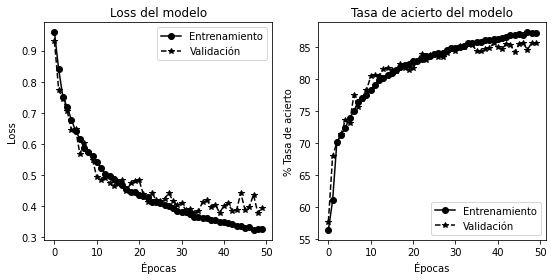

In [61]:
plot_history(history_unet)
plt.savefig("Images/train_unet_da.png")
plt.show()

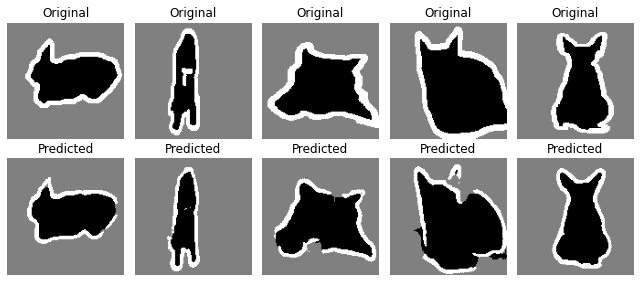

In [57]:
show_results(u_net, train, n=5)
# plt.suptitle("Train")
plt.savefig("Images/images_train_unet_da.png")
plt.show()

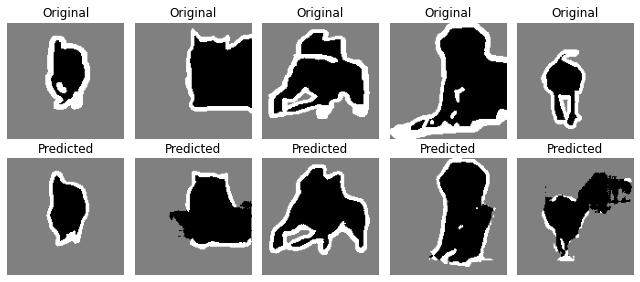

In [58]:
show_results(u_net, test, n=5, random=False)
# plt.suptitle("Test")
plt.savefig("Images/images_test_unet_da.png")
plt.show()